In [4]:
import joblib
stackxg = joblib.load("df_multilabel_hw_cleaned.joblib")

In [5]:
stackxg.head()

,cleaned_text,Tags,Tag_Number
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]"
1,run javascript code server java code want run ...,java javascript,"[1, 3]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]"
3,run python script php server run nginx web ser...,php python,"[2, 7]"
4,advice write function m try write function res...,javascript jquery,"[3, 5]"


**Step 1: One hot encoding of the target labels using MultiLabelBinarizer**

In [6]:
import ast
from ast import literal_eval
stackxg['Tag_Number'] = stackxg['Tag_Number'].apply(literal_eval)
stackxg.head()

,cleaned_text,Tags,Tag_Number
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]"
1,run javascript code server java code want run ...,java javascript,"[1, 3]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]"
3,run python script php server run nginx web ser...,php python,"[2, 7]"
4,advice write function m try write function res...,javascript jquery,"[3, 5]"


In [7]:
!pip install scikit-learn
from sklearn.preprocessing import MultiLabelBinarizer

In [8]:
mlbinarizer = MultiLabelBinarizer()
targets = mlbinarizer.fit_transform(stackxg['Tag_Number'])
targets

array([[1, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

**Step2: Train test split**

In [9]:
from sklearn.model_selection import train_test_split

X, y = list(stackxg['cleaned_text'].values), targets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [11]:
type(y_train1)

numpy.ndarray

**Step 3: Creating Custom datasets for loading the inputs and labels as a tuple**

In [12]:
import torch
class CustomDataset(torch.utils.data.Dataset):
    """
    Custom Dataset class for loading Stack Exchange posts and labels.

    Attributes:
        X (numpy.ndarray): Feature data, an array of texts.
        y (list or array-like): Target labels.
    """

    def __init__(self, X, y):
        """
        Initialize the dataset with feature and target data.

        Args:
            X (list or array-like): The feature data (texts).
            y (list or array-like): The target labels.
        """
        # Storing feature data (texts)
        self.X = X

        # Storing the target labels
        self.y = y

    def __len__(self):
        """
        Return the number of samples in the dataset.

        Returns:
            int: The total number of samples.
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Fetch and return a single sample from the dataset at the given index.

        Args:
            idx (int): Index of the sample to fetch.

        Returns:
            tuple: A tuple containing the label and the text for the sample.
        """
        # Retrieve the text and corresponding label from the dataset using the index
        texts = self.X[idx]
        labels = self.y[idx]

        # Packing them into a tuple before returning
        sample = (labels, texts)

        return sample


In [13]:
# Create an instance of the CustomDataset class for the training set
# This uses the cleaned training data and corresponding labels
trainset = CustomDataset(X_train1,y_train1)

# Create an instance of the CustomDataset class for the validation set
# This uses the cleaned validation data and corresponding labels
validset = CustomDataset(X_val, y_val)

# Create an instance of the CustomDataset class for the test set
# This uses the cleaned test data and corresponding labels
testset = CustomDataset(X_test, y_test)

**Step 5: Creating Vocabulary**

In [14]:
from collections import Counter, OrderedDict
from typing import Dict, List, Optional, Union

class Vocab:
    def __init__(self, tokens: List[str]) -> None:
        self.itos: List[str] = tokens
        self.stoi: Dict[str, int] = {token: i for i, token in enumerate(tokens)}
        self.default_index: Optional[int] = None

    def __getitem__(self, token: str) -> int:
        if token in self.stoi:
            return self.stoi[token]
        if self.default_index is not None:
            return self.default_index
        raise RuntimeError(f"Token '{token}' not found in vocab")

    def __contains__(self, token: str) -> bool:
        return token in self.stoi

    def __len__(self) -> int:
        return len(self.itos)

    def insert_token(self, token: str, index: int) -> None:
        if index < 0 or index > len(self.itos):
            raise ValueError("Index out of range")
        if token in self.stoi:
            old_index = self.stoi[token]
            if old_index < index:
                self.itos.pop(old_index)
                self.itos.insert(index - 1, token)
            else:
                self.itos.pop(old_index)
                self.itos.insert(index, token)
        else:
            self.itos.insert(index, token)

        self.stoi = {token: i for i, token in enumerate(self.itos)}

    def append_token(self, token: str) -> None:
        if token in self.stoi:
            raise RuntimeError(f"Token '{token}' already exists in the vocab")
        self.insert_token(token, len(self.itos))

    def set_default_index(self, index: Optional[int]) -> None:
        self.default_index = index

    def get_default_index(self) -> Optional[int]:
        return self.default_index

    def lookup_token(self, index: int) -> str:
        if 0 <= index < len(self.itos):
            return self.itos[index]
        raise RuntimeError(f"Index {index} out of range")

    def lookup_tokens(self, indices: List[int]) -> List[str]:
        return [self.lookup_token(index) for index in indices]

    def lookup_indices(self, tokens: List[str]) -> List[int]:
        return [self[token] for token in tokens]

    def get_stoi(self) -> Dict[str, int]:
        return self.stoi.copy()

    def get_itos(self) -> List[str]:
        return self.itos.copy()

    @classmethod
    def vocab(cls, ordered_dict: Union[OrderedDict, Counter], min_freq: int = 1, specials: Optional[List[str]] = None, special_first: bool = True) -> 'Vocab':
        specials = specials or []
        for token in specials:
            ordered_dict.pop(token, None)

        tokens = [token for token, freq in ordered_dict.items() if freq >= min_freq]

        if special_first:
            tokens = specials + tokens
        else:
            tokens = tokens + specials

        return cls(tokens)

In [15]:
def get_vocab(dataset, min_freq=1):
    """
    Generate a vocabulary from a dataset.

    Args:
        dataset (list of tuple): List of tuples where each tuple contains a label and a text.
        min_freq (int): The minimum frequency for a token to be included in the vocabulary.

    Returns:
        torchtext.vocab.Vocab: Vocabulary object.
    """
    # Initialize a counter object to hold token frequencies
    counter = Counter()

    # Update the counter with tokens from each text in the dataset
    for (label, text) in dataset:
        counter.update(text.split())

    # Create a vocabulary using the counter object
    # Tokens that appear fewer times than `min_freq` are excluded
    my_vocab = Vocab.vocab(counter, min_freq=min_freq)

    # Insert a '<unk>' token at index 0 to represent unknown words
    my_vocab.insert_token('<unk>', 0)

    # Set the default index to 0
    # This ensures that any unknown word will be mapped to '<unk>'
    my_vocab.set_default_index(0)

    return my_vocab

In [16]:
stckexg_vocab = get_vocab(trainset, min_freq=2)

In [17]:
len(stckexg_vocab)

96934

In [18]:
stckexg_vocab.get_itos()[0:5]

['<unk>', 'nullpointerexception', 'run', 'figure', 'return']

In [19]:
stckexg_vocab["hkfhekrferfjvl"]

0

In [20]:
# Creating a function that will be used to get the indices of words from vocab
def tokenizer(x, vocab):
    """Converts text to a list of indices using a vocabulary dictionary"""
    return [vocab[token] for token in x.split()]

**Step 6 : Collate function to create labels texts and offsets**

In [21]:
def collate_batch(batch, my_vocab):
    """
    Collates a batch of samples into tensors of labels, texts, and offsets.

    Parameters:
        batch (list): A list of tuples, each containing a label and a text.

    Returns:
        tuple: A tuple containing three tensors:
               - Labels tensor
               - Concatenated texts tensor
               - Offsets tensor indicating the start positions of each text in the concatenated tensor
    """
    # Unpack the batch into separate lists for labels and texts
    labels,texts = zip(*batch)

    # Convert the list of labels into a tensor of dtype int32
    labels = torch.tensor(labels, dtype=torch.float32)
    # Convert the list of texts into a list of lists; each inner list contains the vocabulary indices for a text
    list_of_list_of_indices = [tokenizer(text, my_vocab) for text in texts]

    # Concatenate all text indices into a single tensor
    indices = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])

    # Compute the offsets for each text in the concatenated tensor
    offsets = [0] + [len(i) for i in list_of_list_of_indices]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

    return (indices, offsets), labels

In [22]:
from functools import partial
batch_size = 2
collate_partial = partial(collate_batch, my_vocab = stckexg_vocab)
check_loader = torch.utils.data.DataLoader(dataset=trainset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           collate_fn=collate_partial,
                                           )

In [23]:
torch.manual_seed(22)
for (indices, offset), label in check_loader:
    print(indices, offset, label)
    break

tensor([  167, 26747,  1069,   102,   270,   167, 26747,   466,  6167,   167,
          514,   402,   402,    12, 26747,   428,   655,   177,   180,   604,
         4255,   601,  1904,   604,   229,   449,   649,     6,   466,   180,
        20852,   708,  1538,  1633,    95,  2806,   467,  1053,   467,  1053,
          272,  1505,   253,  1012,   425,  1053,  1069,   274,   466,   200,
        67589,   185,   200, 67590,   136, 67591, 67592,   136, 67593, 67594,
          136,   242,   613,  5310,  1053,   425, 67595, 67596,   613,   263,
          200, 67597,   185, 67595, 67596,   613,   408]) tensor([ 0, 35]) tensor([[0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0., 0., 0.]])


<ipython-input-21-3d05a53ae8ff>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  labels = torch.tensor(labels, dtype=torch.float32)


**Step 7: Defining Neural Network with following layers. EmbeddingBag_layer->Linear->ReLU->BatchNorm->Dropout->Linear->ReLU->BatchNorm->Dropout->Linear**

In [24]:
import torch.nn as nn

class SimpleMLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim1, hidden_dim2, drop_prob1, drop_prob2, num_outputs):
        super().__init__()

        # Embedding layer
        self.embedding_bag = nn.EmbeddingBag(vocab_size, embedding_dim)

        # First Linear layer
        self.linear1 = nn.Linear(embedding_dim, hidden_dim1)
        # Batch normalization for first linear layer
        self.batchnorm1 = nn.BatchNorm1d(num_features=hidden_dim1)
        # Dropout for first linear layer
        self.dropout1 = nn.Dropout(p=drop_prob1)

        # Second Linear layer
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        # Batch normalization for second linear layer
        self.batchnorm2 = nn.BatchNorm1d(num_features=hidden_dim2)
        # Dropout for second linear layer
        self.dropout2 = nn.Dropout(p=drop_prob2)

        # Final Linear layer (output layer)
        self.linear3 = nn.Linear(hidden_dim2, num_outputs)

    def forward(self, input_tuple):
        indices, offsets = input_tuple

        # Pass data through the embedding layer
        x = self.embedding_bag(indices, offsets)

        # First linear layer followed by ReLU, BatchNorm, and Dropout
        x = self.linear1(x)
        x = nn.ReLU()(x)
        x = self.dropout1(x)
        x = self.batchnorm1(x)

        # Second linear layer followed by ReLU, BatchNorm, and Dropout
        x = self.linear2(x)
        x = nn.ReLU()(x)
        x = self.batchnorm2(x)
        x = self.dropout2(x)

        # Final linear layer
        x = self.linear3(x)

        # Apply sigmoid activation for multilabel classification
        #x = torch.sigmoid(x)

        return x


In [25]:
!pip install torchinfo

In [26]:
from torchinfo import summary
# Define the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Define the sequential model
# this will invoke the __init__() function of the model
model = SimpleMLP(vocab_size=7 , embedding_dim=10, hidden_dim1=5, hidden_dim2=3, drop_prob1=0.5, drop_prob2=0.5, num_outputs=10)

# Move the model to the device
model = model.to(device)

# Generate some dummy input data and offsets, and move them to the device
data = torch.tensor([1, 2, 4, 5, 4], dtype = torch.int32).to(device)
offsets = torch.tensor([0, 2, 4], dtype = torch.int32).to(device)

# Generate summary
summary(model, input_data=[(data, offsets)], device=device, depth =10, verbose = False)

Layer (type:depth-idx)                   Output Shape              Param #
SimpleMLP                                [3, 10]                   --
├─EmbeddingBag: 1-1                      [3, 10]                   70
├─Linear: 1-2                            [3, 5]                    55
├─Dropout: 1-3                           [3, 5]                    --
├─BatchNorm1d: 1-4                       [3, 5]                    10
├─Linear: 1-5                            [3, 3]                    18
├─BatchNorm1d: 1-6                       [3, 3]                    6
├─Dropout: 1-7                           [3, 3]                    --
├─Linear: 1-8                            [3, 10]                   40
Total params: 199
Trainable params: 199
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [27]:
# Since nn.Sequential expects a single input, we pack data and offsets into a tuple
# this will invoke the forward function of the model
output = model((data, offsets))

print(output)

tensor([[-0.3215,  0.1474,  0.5562, -0.0196,  0.4182, -1.4106,  0.9407, -1.1703,
         -0.4261,  1.5818],
        [-0.5728,  0.8710,  0.8568,  0.1602,  0.0215, -1.7831,  1.4146, -0.7505,
          0.2129,  2.0491],
        [ 2.0511,  0.6198,  0.2110,  1.2029,  0.5455,  2.1920, -0.4989,  1.3383,
         -0.6484, -1.7434]], device='cuda:0', grad_fn=<AddmmBackward0>)


**Step 7: Step function for forward and backward pass**

In [28]:
def step(inputs, targets, model, device, loss_function=None, optimizer=None,CLIP_TYPE="value",CLIP_VALUE=10):
    """
    Performs a forward and backward pass for a given batch of inputs and targets.

    Parameters:
    - inputs (torch.Tensor): The input data for the model.
    - targets (torch.Tensor): The true labels for the input data.
    - model (torch.nn.Module): The neural network model.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module, optional): The loss function to use.
    - optimizer (torch.optim.Optimizer, optional): The optimizer to update model parameters.

    Returns:
    - loss (float): The computed loss value (only if loss_function is not None).
    - outputs (torch.Tensor): The predictions from the model.
    - correct (int): The number of correctly classified samples in the batch.
    """
    # Move the model and data to the device
    model = model.to(device)

    #### Changed this from last file ############
    inputs = tuple(input_tensor.to(device)
                            for input_tensor in inputs)

    targets = targets.to(device)

    # Step 1: Forward pass to get the model's predictions
    outputs = model(inputs)

    # Step 2a: Compute the loss using the provided loss function
    if loss_function:
        loss = loss_function(outputs, targets)
    #sigmoid for MUltilabel classification
    sigmoid_outputs = torch.sigmoid(outputs)
    predicted = (sigmoid_outputs > 0.5).float()

    # Step 2b: Calculate the number of correctly classified samples
    correct = (predicted == targets).sum().item()

    # Step 3 and 4: Perform backward pass and update model parameters if an optimizer is provided
    if optimizer:
        optimizer.zero_grad()
        loss.backward()
        # Clip gradients before the optimizer step
        if CLIP_TYPE == 'value':
            torch.nn.utils.clip_grad_value_(model.parameters(), CLIP_VALUE)

        # Update parameters
        optimizer.step()

    # Return relevant metrics
    if loss_function:
        return loss, outputs, correct
    else:
        return None, outputs, correct


**Step 9: Defining Epoch wise training and validation functions**

In [29]:
def train_epoch(train_loader, model, device, loss_function, optimizer):
    """
    Trains the model for one epoch using the provided data loader and updates the model parameters.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader object for the training set.
    - model (torch.nn.Module): The neural network model to be trained.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to use for training.
    - optimizer (torch.optim.Optimizer): The optimizer to update model parameters.

    Returns:
    - train_loss (float): Average training loss for the epoch.
    - train_hamming_loss (float): Training Hamming Loss for the epoch.
    """
    # Set the model to training mode
    model = model.to(device)
    model.train()

    # Initialize variables to track running training loss and Hamming Loss
    running_train_loss = 0.0
    total_hamming_loss = 0.0

    # Iterate over all batches in the training data
    for inputs, targets in train_loader:
        # Perform a forward and backward pass, updating model parameters
        loss, outputs, _ = step(inputs, targets, model, device, loss_function, optimizer)
        outputs = outputs.to(device)
        # Update running loss
        running_train_loss += loss.item()

        # Apply threshold at 0.5 for multilabel classification
        sigmoid_outputs = torch.sigmoid(outputs)
        sigmoid_outputs = sigmoid_outputs.to(device)
        predicted = (sigmoid_outputs > 0.5).float()
        targets = targets.to(device)
        predicted = predicted.to(device)
        # Compute Hamming Loss: fraction of incorrect labels
        batch_hamming_loss = (predicted != targets).float().mean().item()

        # Accumulate Hamming Loss
        total_hamming_loss += batch_hamming_loss

    # Compute average loss and Hamming Loss for the entire training set
    train_loss = running_train_loss / len(train_loader)
    train_hamming_loss = total_hamming_loss / len(train_loader)

    return train_loss, train_hamming_loss


In [30]:
def val_epoch(valid_loader, model, device, loss_function, threshold=0.5):
    """
    Validates the model for one epoch using the provided data loader.

    Parameters:
    - valid_loader (torch.utils.data.DataLoader): DataLoader object for the validation set.
    - model (torch.nn.Module): The neural network model to be validated.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to evaluate the model.
    - threshold (float, optional): Threshold for multilabel classification. Default is 0.5.

    Returns:
    - val_loss (float): Average validation loss for the epoch.
    - val_hamming_loss (float): Validation Hamming Loss for the epoch.
    """
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track running validation loss and Hamming Loss
    running_val_loss = 0.0
    total_hamming_loss = 0.0

    # Disable gradient computation for validation
    with torch.no_grad():
        # Iterate over all batches in the validation data
        for inputs, targets in valid_loader:
            # Move inputs and targets to the appropriate device (CPU or GPU)
            # Move inputs and targets to the device (CPU or GPU)
            inputs = tuple(input_tensor.to(device) for input_tensor in inputs)
            targets = targets.to(device)


            # Perform forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(inputs)

            # Compute the loss
            loss = loss_function(outputs, targets)

            # Update running validation loss
            running_val_loss += loss.item()

            # Compute predictions using the threshold
            sigmoid_outputs = torch.sigmoid(outputs)
            predictions = (outputs > threshold).float()

            # Compute Hamming Loss: fraction of incorrect labels
            batch_hamming_loss = (predictions != targets).float().mean().item()

            # Accumulate the Hamming Loss
            total_hamming_loss += batch_hamming_loss

    # Compute average loss and Hamming Loss for the entire validation set
    val_loss = running_val_loss / len(valid_loader)
    val_hamming_loss = total_hamming_loss / len(valid_loader)

    return val_loss, val_hamming_loss


**Step 10: Train and validates the model**

In [31]:
def train(train_loader, valid_loader, model, optimizer, loss_function, epochs, device, patience=5):
    """
    Trains and validates the model, with early stopping based on validation loss.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
    - valid_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
    - model (torch.nn.Module): Neural network model to train.
    - optimizer (torch.optim.Optimizer): Optimizer algorithm.
    - loss_function (torch.nn.Module): Loss function to evaluate the model.
    - epochs (int): Number of epochs to train the model.
    - device (torch.device): The computing device (CPU or GPU).
    - patience (int): Number of epochs to wait for improvement before stopping early.

    Returns:
    - train_loss_history (list): History of training loss for each epoch.
    - train_hamming_history (list): History of training Hamming Loss for each epoch.
    - valid_loss_history (list): History of validation loss for each epoch.
    - valid_hamming_history (list): History of validation Hamming Loss for each epoch.
    """

    # Initialize lists to store metrics for each epoch
    train_loss_history = []
    valid_loss_history = []
    train_hamming_history = []
    valid_hamming_history = []

    # Early stopping variables
    best_val_loss = float('inf')  # Initialize best validation loss to infinity
    epochs_no_improve = 0         # Counter for epochs with no improvement

    # Loop over the number of specified epochs
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Train model on training data and capture metrics
        train_loss, train_hamming_loss = train_epoch(train_loader, model, device, loss_function, optimizer)

        # Validate model on validation data and capture metrics
        valid_loss, valid_hamming_loss = val_epoch(valid_loader, model, device, loss_function)

        # Store metrics for this epoch
        train_loss_history.append(train_loss)
        train_hamming_history.append(train_hamming_loss)
        valid_loss_history.append(valid_loss)
        valid_hamming_history.append(valid_hamming_loss)

        # Output epoch-level summary
        print(f"Train Loss: {train_loss:.4f} | Train Hamming Loss: {train_hamming_loss:.4f}")
        print(f"Valid Loss: {valid_loss:.4f} | Valid Hamming Loss: {valid_hamming_loss:.4f}")
        print()

        # Early Stopping Logic
        if valid_loss < best_val_loss:
            best_val_loss = valid_loss  # Update best validation loss
            epochs_no_improve = 0       # Reset counter
        else:
            epochs_no_improve += 1      # Increment counter if no improvement

        # Check if patience has been reached
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered. No improvement for {patience} consecutive epochs.")
            break  # Stop training

    return train_loss_history, train_hamming_history, valid_loss_history, valid_hamming_history


**Step 11: Hyper Parameters**

In [32]:
# model Parameters
EMBED_DIM=300
VOCAB_SIZE=len(stckexg_vocab)
HIDDEN_DIM1=200
HIDDEN_DIM2=100
DROP_PROB1=0.5
DROP_PROB2=0.5
NUM_OUTPUTS=10
CLIP_TYPE="value"
CLIP_VALUE=10
# training
EPOCHS=5
BATCH_SIZE=128
LEARNING_RATE=0.001
WEIGHT_DECAY=0.00
PATIENCE = 5

In [33]:
# Fixing the seed value for reproducibility across runs
import random
import numpy as np
import torch
SEED = 2345
random.seed(SEED)                     # Set seed for Python's 'random' module
np.random.seed(SEED)                  # Set seed for NumPy's random number generation
torch.manual_seed(SEED)               # Set seed for PyTorch's CPU operations
torch.cuda.manual_seed(SEED)          # Set seed for PyTorch's CUDA (GPU) operations
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior in CuDNN

# Define collate function with a fixed vocabulary using the 'partial' function
collate_fn = partial(collate_batch, my_vocab=stckexg_vocab)

# Data Loaders for training, validation, and test sets
# These loaders handle batching, shuffling, and data processing using the custom collate function
train_loader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True,
                                           collate_fn=collate_fn, num_workers=2)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False,
                                           collate_fn=collate_fn, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False,
                                          collate_fn=collate_fn, num_workers=2)

# Define the loss function for the model, using cross-entropy loss
loss_function = nn.BCEWithLogitsLoss()

# Define the model with specified hyperparameters
model_imdb = SimpleMLP(vocab_size=VOCAB_SIZE,
                       embedding_dim=EMBED_DIM,
                       hidden_dim1=HIDDEN_DIM1,
                       hidden_dim2=HIDDEN_DIM2,
                       drop_prob1=DROP_PROB1,
                       drop_prob2=DROP_PROB2,
                       num_outputs=NUM_OUTPUTS,
                       )

# Initialize the optimizer for training, using AdamW optimizer with specified learning rate
optimizer = torch.optim.AdamW(model_imdb.parameters(), lr=LEARNING_RATE)

# Define the device for model training (use CUDA if available, else CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


**Step 11: Evaluate performance of untrained model**

In [34]:
for inputs, targets in train_loader:
    # Move inputs and targets to the CPU.
    inputs = tuple(input_tensor.to(device) for input_tensor in inputs)
    targets = targets.to(device)
    model_imdb = model_imdb.to(device)
    model_imdb.eval()
    targets = targets.float()
    # Forward pass
    with torch.no_grad():  # Ensure no gradients are calculated since this is evaluation.
        output = model_imdb(inputs)
        loss = loss_function(output, targets)
        print(f'Actual loss: {loss.item()}')
    break

print(f'Expected Theoretical loss: {-1*np.log(0.5)}')


Actual loss: 0.6891705393791199
Expected Theoretical loss: 0.6931471805599453


In [35]:
# Call the train function to train the model
train_losses, train_acc, valid_losses, valid_acc = train(
    train_loader, valid_loader, model_imdb, optimizer, loss_function, EPOCHS, device,patience=PATIENCE
)

Epoch 1/5
Train Loss: 0.4251 | Train Hamming Loss: 0.1855
Valid Loss: 0.1928 | Valid Hamming Loss: 0.0647

Epoch 2/5
Train Loss: 0.1775 | Train Hamming Loss: 0.0608
Valid Loss: 0.1433 | Valid Hamming Loss: 0.0538

Epoch 3/5
Train Loss: 0.1393 | Train Hamming Loss: 0.0491
Valid Loss: 0.1280 | Valid Hamming Loss: 0.0485

Epoch 4/5
Train Loss: 0.1190 | Train Hamming Loss: 0.0425
Valid Loss: 0.1196 | Valid Hamming Loss: 0.0447

Epoch 5/5
Train Loss: 0.1030 | Train Hamming Loss: 0.0371
Valid Loss: 0.1154 | Valid Hamming Loss: 0.0423



**Step 13: Plot losses of training and validation under each epoch**

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_history(train_losses, train_metrics, val_losses=None, val_metrics=None):
    """
    Plot training and validation loss and metrics over epochs.

    Args:
        train_losses (list): List of training losses for each epoch.
        train_metrics (list): List of training metrics (e.g., accuracy) for each epoch.
        val_losses (list, optional): List of validation losses for each epoch.
        val_metrics (list, optional): List of validation metrics for each epoch.

    Returns:
        None
    """
    # Determine the number of epochs based on the length of train_losses
    epochs = range(1, len(train_losses) + 1)

    # Plotting training and validation losses
    plt.figure()
    plt.plot(epochs, train_losses, label="Train")  # Plot training losses
    if val_losses:  # Check if validation losses are provided
        plt.plot(epochs, val_losses, label="Validation")  # Plot validation losses
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plotting training and validation metrics
    if train_metrics[0] is not None:  # Check if training metrics are available
        plt.figure()
        plt.plot(epochs, train_metrics, label="Train")  # Plot training metrics
        if val_metrics:  # Check if validation metrics are provided
            plt.plot(epochs, val_metrics, label="Validation")  # Plot validation metrics
        plt.xlabel("Epochs")
        plt.ylabel("Metric")
        plt.legend()
        plt.show()



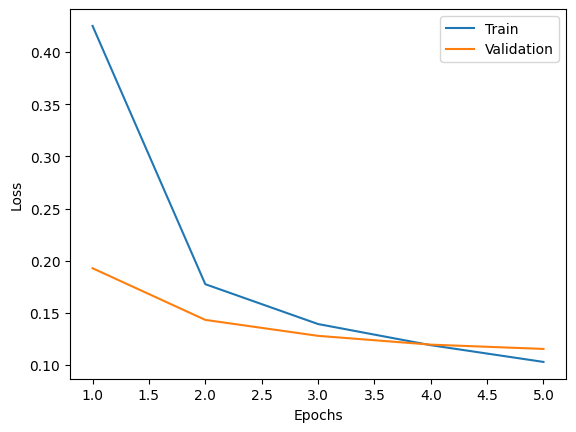

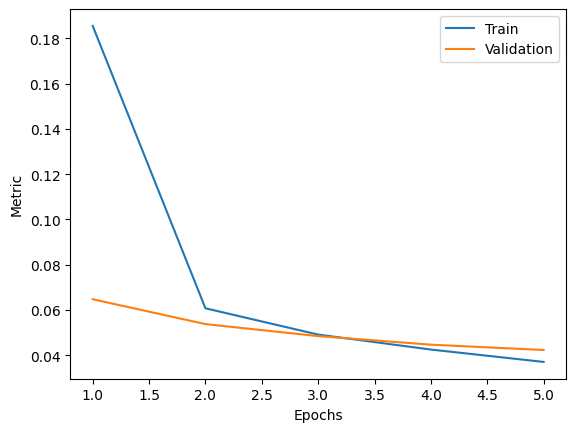

In [37]:
plot_history(train_losses, train_acc, valid_losses, valid_acc)

**Step 14: Evaluating test dataset**

In [38]:
def test_model(test_loader, model, device, loss_function, threshold=0.5):
    """
    Tests the model on the test dataset.

    Args:
        test_loader (DataLoader): DataLoader object for the test set.
        model (nn.Module): Trained neural network model.
        device (torch.device): Device to perform computation (CPU/GPU).
        loss_function (nn.Module): Loss function to compute the test loss.
        threshold (float, optional): Threshold for multilabel classification.

    Returns:
        avg_test_loss (float): Average loss on the test dataset.
        test_hamming_loss (float): Hamming Loss on the test dataset.
    """
    model.eval()  # Set the model to evaluation mode
    running_test_loss = 0.0
    total_hamming_loss = 0.0
    num_batches = 0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, targets in test_loader:
            # Move inputs and targets to the device
            inputs = tuple(input_tensor.to(device) for input_tensor in inputs)
            targets = targets.to(device).float()

            # Forward pass to get outputs
            outputs = model(inputs)

            # Compute the loss
            loss = loss_function(outputs, targets)
            running_test_loss += loss.item()

            # Apply sigmoid to get probabilities, then threshold to classify
            sigmoid_outputs = torch.sigmoid(outputs)
            predictions = (sigmoid_outputs > threshold).float()

            # Compute Hamming Loss: fraction of incorrect labels
            batch_hamming_loss = (predictions != targets).float().mean().item()
            total_hamming_loss += batch_hamming_loss

            num_batches += 1

    # Compute average test loss and Hamming Loss
    avg_test_loss = running_test_loss / num_batches
    avg_hamming_loss = total_hamming_loss / num_batches

    print(f"Test Loss: {avg_test_loss:.4f}, Test Hamming Loss: {avg_hamming_loss:.4f}")

    return avg_test_loss, avg_hamming_loss


In [39]:
# Assuming test_loader, model, device, and loss_function are defined
test_loss, test_hamming_loss = test_model(test_loader, model_imdb, device, loss_function)

# Print results
print(f"Test Loss: {test_loss}, Test Hamming Loss: {test_hamming_loss}")


Test Loss: 0.1106, Test Hamming Loss: 0.0399
Test Loss: 0.11059678932030996, Test Hamming Loss: 0.03988541747132937


**Inference:**

#### 1. **Model Overview**:
   - The model used was a **Simple Multi-Layer Perceptron (MLP)** architecture, designed for a multilabel classification task with 10 output labels. The architecture consisted of:
     - **EmbeddingBag Layer**: Used for embedding the vocabulary.
     - **Two Hidden Layers**: Each followed by ReLU activation, Batch Normalization, and Dropout to mitigate overfitting.
     - **Output Layer**: Producing raw logits, followed by sigmoid activation for multilabel classification.
   - **BCEWithLogitsLoss** was used as the loss function, suitable for the multilabel classification problem.

#### 2. **Training Process**:
   - The model was trained for **5 epochs** with early stopping, with a patience of **5** epochs to prevent overfitting if the validation loss didn’t improve.
   - The training set consisted of tokenized text data converted into tensors using a custom vocabulary created from the dataset. A **collate function** was used to ensure proper batch creation.

#### 3. **Hyperparameters**:
   - **Embedding Dimension**: 300
   - **Hidden Layer Dimensions**: 200 and 100 neurons, respectively.
   - **Dropout Probability**: 0.5 for both hidden layers to avoid overfitting.
   - **Learning Rate**: 0.001, using the AdamW optimizer.
   - **Batch Size**: 128

#### 4. **Performance Metrics**:
   - The performance of the model was evaluated using **Hamming Loss**, which measures the fraction of labels that are incorrectly predicted for each sample. Lower values of Hamming Loss indicate better performance.
   - **Training and Validation Results**:
Epoch 1/5
Train Loss: 0.4251 | Train Hamming Loss: 0.1855
Valid Loss: 0.1928 | Valid Hamming Loss: 0.0647

Epoch 2/5
Train Loss: 0.1775 | Train Hamming Loss: 0.0608
Valid Loss: 0.1433 | Valid Hamming Loss: 0.0538

Epoch 3/5
Train Loss: 0.1393 | Train Hamming Loss: 0.0491
Valid Loss: 0.1280 | Valid Hamming Loss: 0.0485

Epoch 4/5
Train Loss: 0.1190 | Train Hamming Loss: 0.0425
Valid Loss: 0.1196 | Valid Hamming Loss: 0.0447

Epoch 5/5
Train Loss: 0.1030 | Train Hamming Loss: 0.0371
Valid Loss: 0.1154 | Valid Hamming Loss: 0.0423

#### 5. **Test Set Evaluation**:
   - After training, the model was evaluated on the test set to measure generalization to unseen data.
   - **Test Results**:
     Test Loss: **0.1106**, Test Hamming Loss: **0.0399**
   - These results demonstrate that the model generalized well, with low Hamming Loss on both the validation and test sets, indicating the model's predictions were accurate for most labels.

#### 6. **Observations and Insights**:
   - **Early Stopping**: The early stopping mechanism prevented the model from overfitting, as it stopped training after 5 epochs where no significant improvements were observed in the validation loss.
   - **Performance on Multilabel Classification**: The model achieved a low Hamming Loss, demonstrating that it was able to predict multiple labels for each sample with a high degree of accuracy.
   - **Training Stability**: Both training and validation losses decreased consistently over the epochs, showing that the model did not overfit and learned effectively from the training data.

In [52]:
import torch

def preprocess_text(text, vocab):
    """
    Preprocess the input text by converting it to indices and computing offsets.

    Parameters:
    - text (str): The input text to preprocess.
    - vocab (Vocab): The vocabulary used to convert words to indices.

    Returns:
    - indices (Tensor): Tensor of word indices.
    - offsets (Tensor): Offsets for each sequence.
    """
    # Convert each word in the text to its corresponding index in the vocabulary
    indices = [vocab[word] for word in text.split() if word in vocab]

    # Convert the list of indices into a PyTorch tensor
    indices = torch.tensor(indices, dtype=torch.int64)

    # The offset is needed when using EmbeddingBag (assuming batch size = 1)
    offsets = torch.tensor([0], dtype=torch.int64)

    return indices, offsets

def run_inference(model, text, vocab, device, threshold=0.5):
    """
    Run inference on new text data using a trained model.

    Parameters:
    - model (nn.Module): The trained model.
    - text (str): Input text for inference.
    - vocab (Vocab): The vocabulary used during training.
    - device (torch.device): The device to perform inference (CPU/GPU).
    - threshold (float): Threshold for converting logits to binary class labels.

    Returns:
    - predicted_classes (list): List of predicted class labels.
    """
    # Preprocess the text (convert to indices and compute offsets)
    indices, offsets = preprocess_text(text, vocab)

    # Move inputs to the device
    indices = indices.to(device)
    offsets = offsets.to(device)

    # Move model to the device and set it to evaluation mode
    model = model.to(device)
    model.eval()

    # Disable gradient calculations for inference
    with torch.no_grad():
        # Pass the indices and offsets to the model to get logits
        logits = model((indices, offsets))

        # Apply sigmoid to convert logits to probabilities
        probabilities = torch.sigmoid(logits)

        # Apply threshold to get binary predictions
        predictions = (probabilities > threshold).float()

    # Convert predictions to a list of class labels (0/1)
    predicted_classes = predictions.cpu().numpy().tolist()
    transformed_classes = []
    for i in range(len(predicted_classes)):
      for j in range(len(predicted_classes[i])):
        if predicted_classes[i][j] == 1.0:
            transformed_classes.append(j)
    return transformed_classes,predicted_classes

# Example Usage:
# Assuming `trained_model` is the trained model, `vocab` is the vocabulary used, and `device` is your device
for i in range(5):
  transformed,predictions = run_inference(model_imdb, X_test[i], stckexg_vocab, device)

# Print the predicted class labels
  print("Transformed Predictions: observation ",i, transformed)
  print("One hot Predictions: observation ",i, predictions)


Transformed Predictions: observation  0 [3, 5]
One hot Predictions: observation  0 [[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]]
Transformed Predictions: observation  1 [0, 9]
One hot Predictions: observation  1 [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]
Transformed Predictions: observation  2 [1, 4]
One hot Predictions: observation  2 [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Transformed Predictions: observation  3 [1]
One hot Predictions: observation  3 [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Transformed Predictions: observation  4 [3, 5]
One hot Predictions: observation  4 [[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]]
